# CNN 7 - Data Augmentation
- Dataset:
    - https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset
- The dataset isn't deep-learning-compatible by default, here's how to preprocess it:
    - Video: https://www.youtube.com/watch?v=O7EV2BjOXus&ab_channel=BetterDataScience
    - Article: https://betterdatascience.com/top-3-prerequisites-for-deep-learning-projects
    - Code: https://github.com/better-data-science/TensorFlow/blob/main/008_CNN_001_Working_With_Image_Data.ipynb


**What you should know by now:**
- How to preprocess image data
- How to load image data from a directory
- What's a convolution, pooling, and a fully-connected layer
- Categorical vs. binary classification

- To start, let's get the library imports out of the way
- We only need a few
- The `plot_image()` function plots a single image from an array

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image


def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray');

- Let's load a sample image:

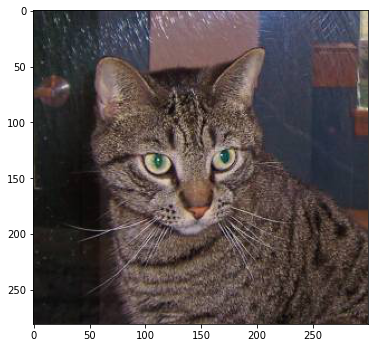

In [9]:
img = Image.open('data/train/cat/1.jpg')
img = np.array(img)
plot_image(img=img)

<br>

## Data Augmentation with TensorFlow in Action
- We can declare a model that *does* different things to an image
- For example, the model below will resize the image to 224x224 and rescale the underlying matrix to a 0-1 range:

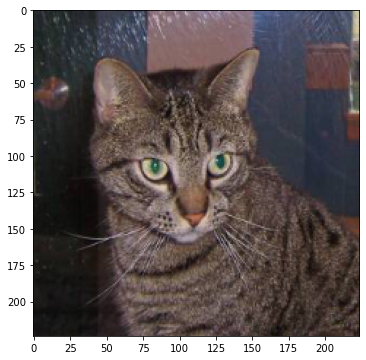

In [10]:
resize_and_scale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255)
])

res = resize_and_scale(img)
plot_image(img=res)

- You typically handle resizing inside the `flow_from_directory()` function, but you can also use it here
- The more interesting transformations are random flips and rotations
    - A `RandomFlip` will flip the image horizontally, vertically, or both, depending on the mode parameter
    - A `RandomRotation` will rotate the image by some some factor (0.2 means 0.2 * 2PI)

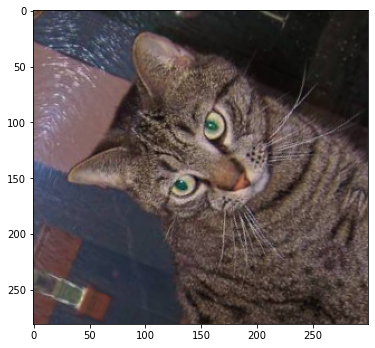

In [11]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.2)
])

res = augmentation(img)
plot_image(img=res)

- Let's extend it even more!
    - A `RandomZoom` will zoom images - 0.2 means 20%
    - A `RandomTranslation` shifts the image (height = vertically, width = horizontally) - 0.2 means 20%

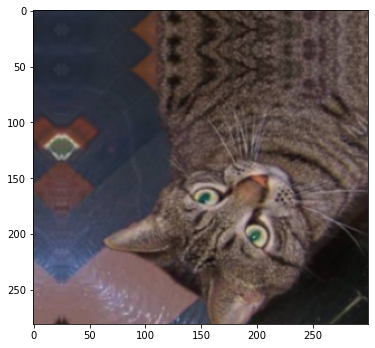

In [15]:
augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

res = augmentation(img)
plot_image(img=res)

- To verify these transformations are indeed random, we can make a 3x3 plot showing results of 9 random transformations:

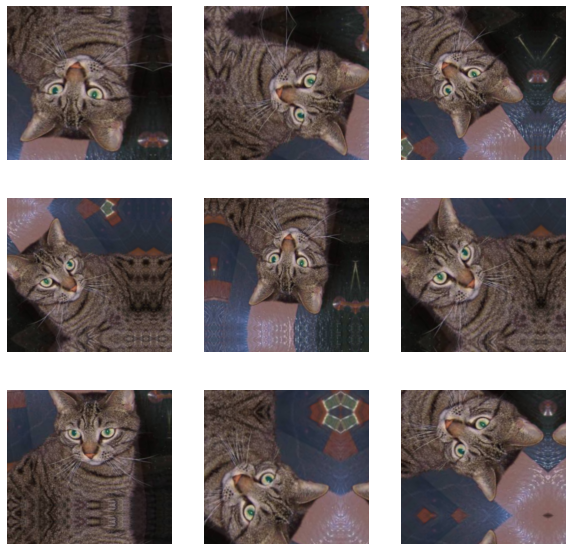

In [16]:
plt.figure(figsize=(10, 10))

for i in range(9):
    img_aug = augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img_aug)
    plt.axis('off')

- Some of them make sense, while others don't - but you can always classify the image as a cat
- Next, let's see how to handle data augmentation with TensorFlow's `ImageDataGenerator`

<br>

## Data Augmentation with TensorFlow's ImageDataGenerator
- You now know what individual transformations do to an image, but it isn't common to write data augmentation as a separate sequential model
- It's more common to apply the transformations when loading the data - with TensorFlow's `ImageDataGenerator`
- **Keep in mind** - You should only augment training data!

In [2]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
)

- We'll now visualize a single batch of images to see if transformations worked
- Load in the test set:

In [3]:
train_data = train_datagen.flow_from_directory(
    directory='data/train/',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42
)

Found 20030 images belonging to 2 classes.


- Extract the first batch:

In [19]:
first_batch = train_data.next()

In [20]:
first_batch[0].shape, first_batch[1].shape

((64, 224, 224, 3), (64, 2))

- A function to visualize 64 images at once:

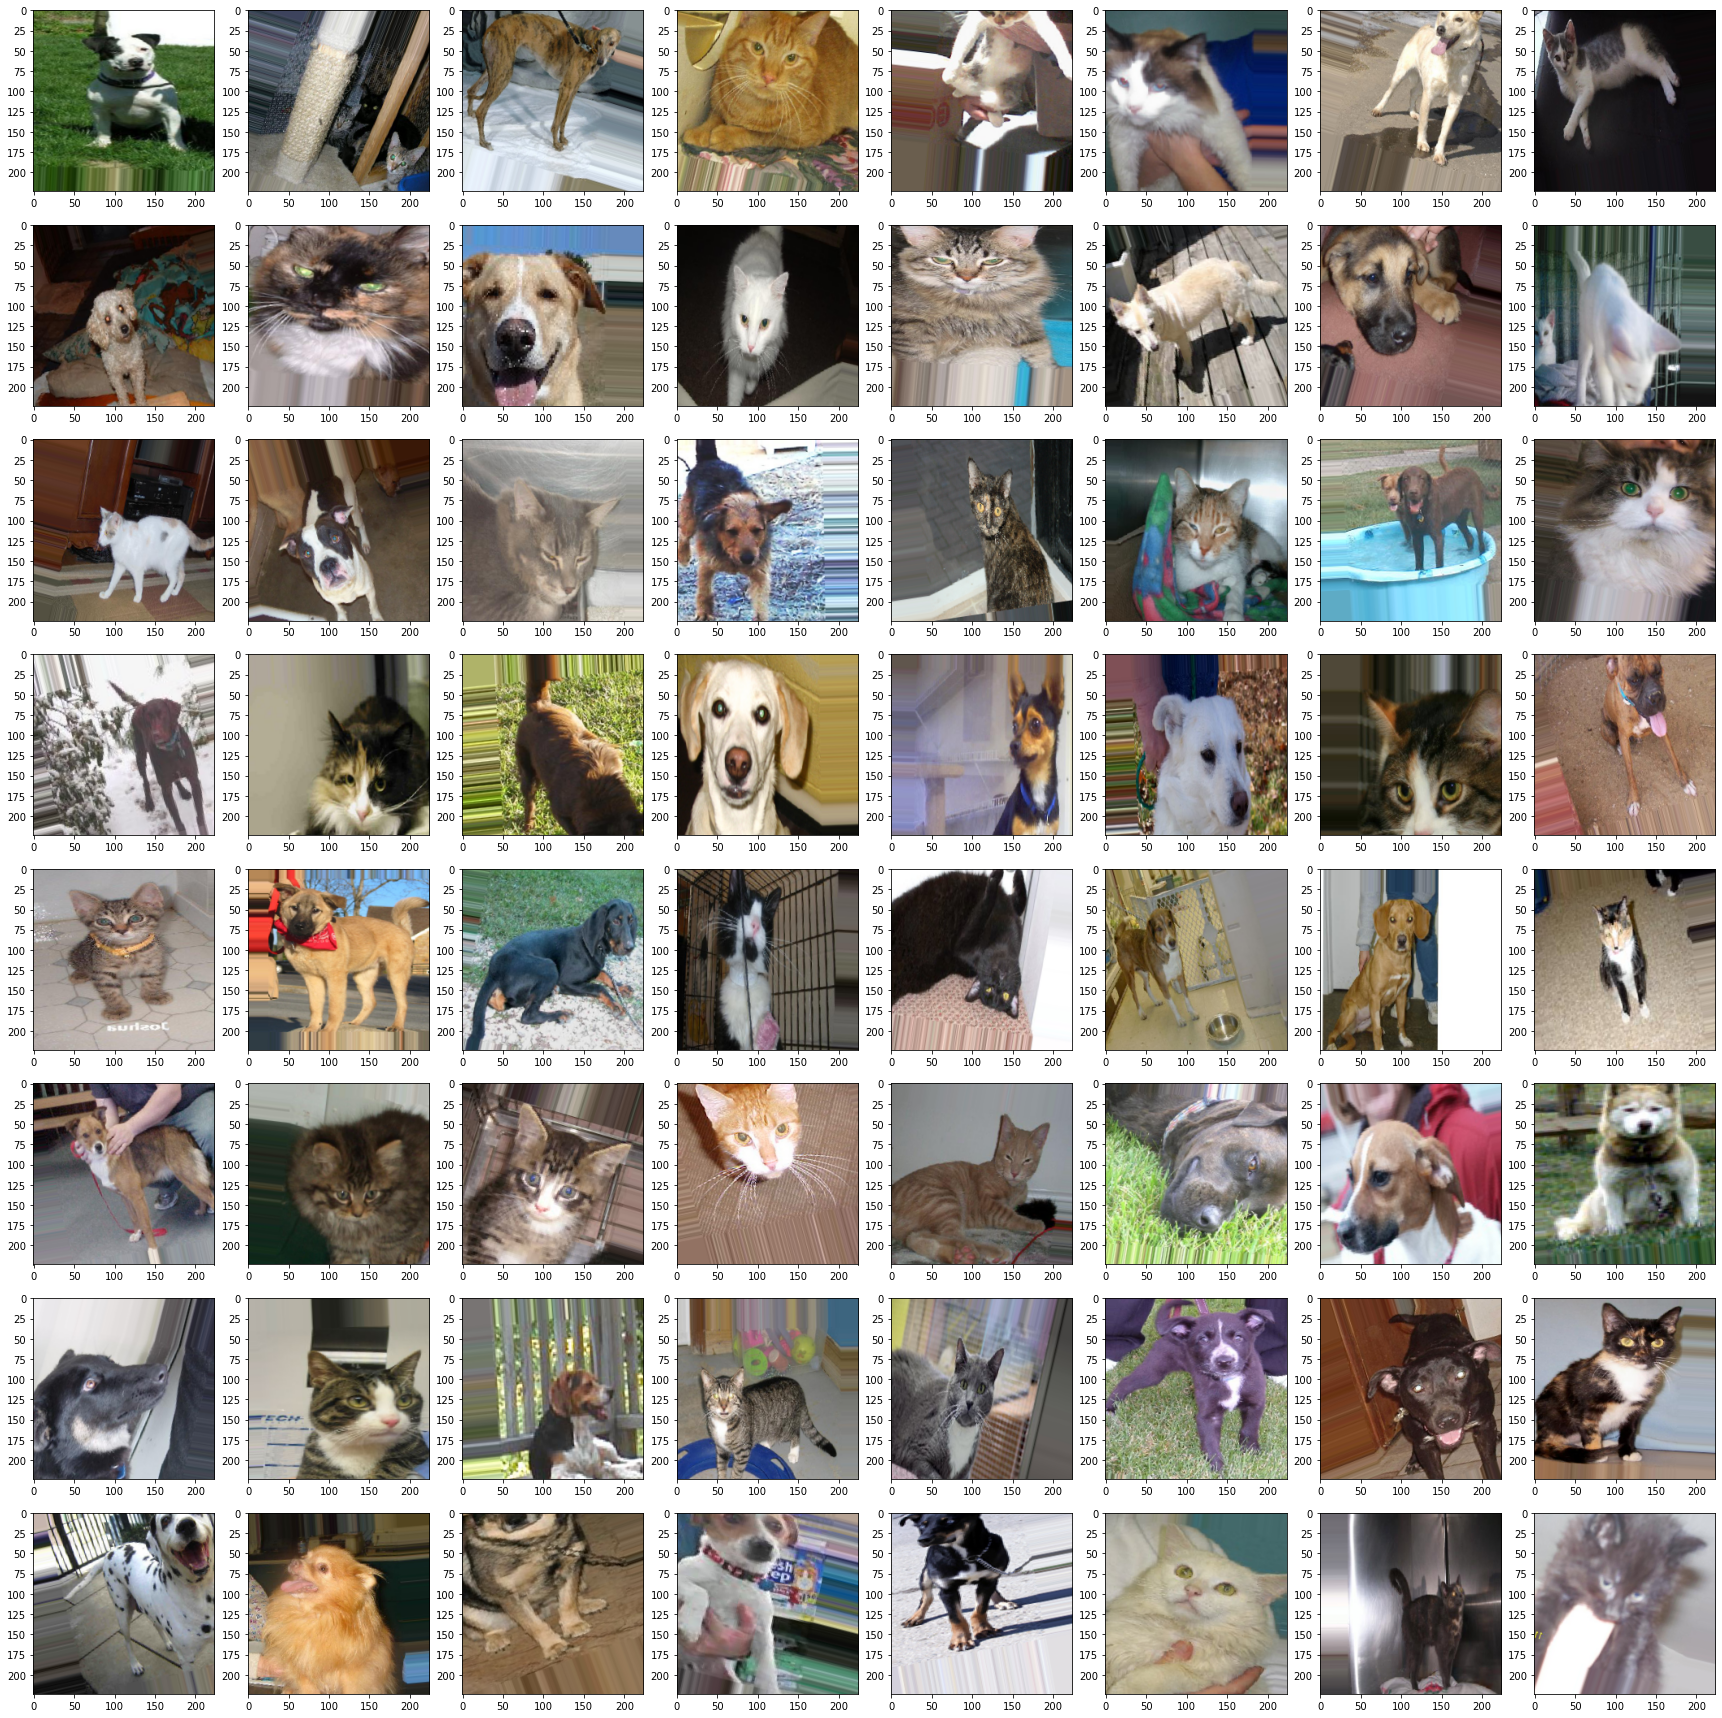

<Figure size 432x288 with 0 Axes>

In [21]:
def visualize_batch(batch: tf.keras.preprocessing.image.DirectoryIterator):
    n = 64
    num_row, num_col = 8, 8
    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))
    
    for i in range(n):
        img = np.array(batch[0][i] * 255, dtype='uint8')
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)
        
    plt.tight_layout()
    plt.show()


visualize_batch(batch=first_batch)

- We definitely have some weird ones, but overall, data augmentation is doing a decent job by adding variety to our dataset
- Finally, let's load in both training and validation images
    - We need to reset the training images because we went over the first batch

In [4]:
train_data = train_datagen.flow_from_directory(
    directory='data/train/',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    directory='data/validation/',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42
)

Found 20030 images belonging to 2 classes.
Found 2478 images belonging to 2 classes.


- And now we can train the model!

<br>

## Model Training - Can Data Augmentation Improve Accuracy?
- We'll use the same model architecture we used when first training an image classifier with CNNs
- It resulted in 75% accuracy on the validation set
- Training the same model on augmented data should improve the validation accuracy
- **Note**: I'm facing some GPU issues so the model was actually trained on the CPU, hence the long training time
    - RTX3060Ti usually goes over an epoch in 22 seconds

In [8]:
model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

Epoch 1/10
313/313 [==============================] - 133s 425ms/step - loss: 0.7610 - accuracy: 0.5842 - val_loss: 0.6212 - val_accuracy: 0.6517
Epoch 2/10
313/313 [==============================] - 134s 427ms/step - loss: 0.6253 - accuracy: 0.6520 - val_loss: 0.6101 - val_accuracy: 0.6731
Epoch 3/10
313/313 [==============================] - 133s 425ms/step - loss: 0.5836 - accuracy: 0.6927 - val_loss: 0.5469 - val_accuracy: 0.7203
Epoch 4/10
313/313 [==============================] - 132s 421ms/step - loss: 0.5550 - accuracy: 0.7161 - val_loss: 0.5106 - val_accuracy: 0.7567
Epoch 5/10
313/313 [==============================] - 132s 420ms/step - loss: 0.5374 - accuracy: 0.7293 - val_loss: 0.5178 - val_accuracy: 0.7474
Epoch 6/10
313/313 [==============================] - 131s 419ms/step - loss: 0.5197 - accuracy: 0.7398 - val_loss: 0.4786 - val_accuracy: 0.7676
Epoch 7/10
313/313 [==============================] - 131s 419ms/step - loss: 0.5047 - accuracy: 0.7483 - val_loss: 0.4746 -

- We've increased the validation accuracy by almost 3%
- It's definitely a step in the right direction, and a way to improve it even further is by using **transfer learning**
    - You'll learn all about it in the next notebook